# US Airline Twitter Sentiment Analysis

## Topic

## Objectives

## Summary

## Importing libraries

In [60]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from datetime import datetime as dt
sns.set(rc = {'figure.figsize':(15,8)})

from sklearn.preprocessing import OneHotEncoder

import nltk
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer 
from nltk.tokenize import RegexpTokenizer


from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from gensim.models import Word2Vec, KeyedVectors, FastText
from gensim.test.utils import common_texts
from gensim.models.fasttext import load_facebook_model
from sklearn.manifold import TSNE

## Uploading the data set

In [61]:
tweets = pd.read_csv(r'C:\Users\imane\OneDrive\Desktop\Sentiment_analysis\Tweets.csv', sep =",")
tweets.head()

,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone
0,570306133677760513,neutral,1.0000,NaN,NaN,Virgin America,NaN,cairdin,NaN,0,@VirginAmerica What @dhepburn said.,NaN,2015-02-24 11:35:52 -0800,NaN,Eastern Time (US & Canada)
1,570301130888122368,positive,0.3486,NaN,0.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica plus you've added commercials t...,NaN,2015-02-24 11:15:59 -0800,NaN,Pacific Time (US & Canada)
2,570301083672813571,neutral,0.6837,NaN,NaN,Virgin America,NaN,yvonnalynn,NaN,0,@VirginAmerica I didn't today... Must mean I n...,NaN,2015-02-24 11:15:48 -0800,Lets Play,Central Time (US & Canada)
3,570301031407624196,negative,1.0000,Bad Flight,0.7033,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica it's really aggressive to blast...,NaN,2015-02-24 11:15:36 -0800,NaN,Pacific Time (US & Canada)
4,570300817074462722,negative,1.0000,Can't Tell,1.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica and it's a really big bad thing...,NaN,2015-02-24 11:14:45 -0800,NaN,Pacific Time (US & Canada)


In [62]:
tweets.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14640 entries, 0 to 14639
Data columns (total 15 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   tweet_id                      14640 non-null  int64  
 1   airline_sentiment             14640 non-null  object 
 2   airline_sentiment_confidence  14640 non-null  float64
 3   negativereason                9178 non-null   object 
 4   negativereason_confidence     10522 non-null  float64
 5   airline                       14640 non-null  object 
 6   airline_sentiment_gold        40 non-null     object 
 7   name                          14640 non-null  object 
 8   negativereason_gold           32 non-null     object 
 9   retweet_count                 14640 non-null  int64  
 10  text                          14640 non-null  object 
 11  tweet_coord                   1019 non-null   object 
 12  tweet_created                 14640 non-null  object 
 13  t

The dataset contains numerical and cetegorical features with 14 640 rows. It gives us information about the tweets such as their ids,  location, overall sentiment and how confident the client is about it, negative reasons and their confidence level, the timestamp of when the tweet was created and most importantly the test written by the reviewers.

### Checking missing values

<AxesSubplot:>

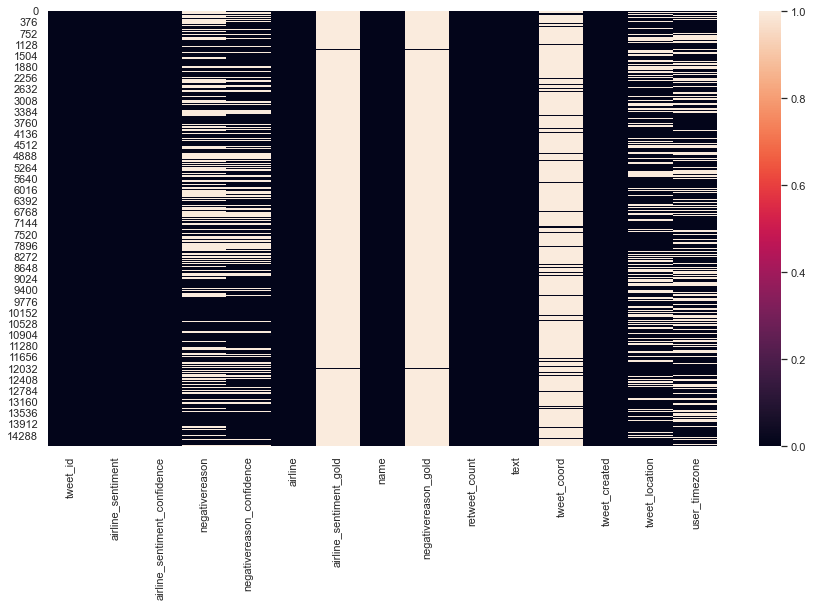

In [63]:
sns.heatmap(tweets.isnull())

There seems to be a lot os missing data especially in the sentiment gold section and tweet coordinates and location. Luckily these columns aren't very important to this study.

In [64]:
def table (df):
    missing = df.isnull().sum()
    missing_perc = df.isnull().sum() * 100/ len(df)
    missing_df = pd.concat([missing,missing_perc], axis = 1)
    missing_df = missing_df.rename(columns={0:"n missing",1:"n percentage"})
    return missing_df

In [65]:
missing = table(tweets)
missing = missing.round(1)
missing.drop(missing.index[(missing["n percentage"] == 0.0)],axis = 0 , inplace = True)
missing = missing.sort_values(by = ["n percentage"],ascending = False)
missing = missing.reset_index()
missing

,index,n missing,n percentage
0,negativereason_gold,14608,99.8
1,airline_sentiment_gold,14600,99.7
2,tweet_coord,13621,93.0
3,negativereason,5462,37.3
4,user_timezone,4820,32.9
5,tweet_location,4733,32.3
6,negativereason_confidence,4118,28.1


I will go ahead and delete the column that have more than 90% missing values, the ids column, names and timezones for now. 

In [66]:
tweets.drop(tweets.columns[[8,6,7,14,11, 0]], axis=1, inplace=True)

### Checking unique categories

In [67]:
objects = tweets.select_dtypes("object")
objects.describe().transpose()

,count,unique,top,freq
airline_sentiment,14640,3,negative,9178
negativereason,9178,10,Customer Service Issue,2910
airline,14640,6,United,3822
text,14640,14427,@united thanks,6
tweet_created,14640,14247,2015-02-24 09:54:34 -0800,5
tweet_location,9907,3081,"Boston, MA",157


Here we see the number of unique categories per categorical feature. I'll be using them in dataviz.

## Exploratory data analysis

[Text(0.5, 1.0, 'Number of reviews by airline ')]

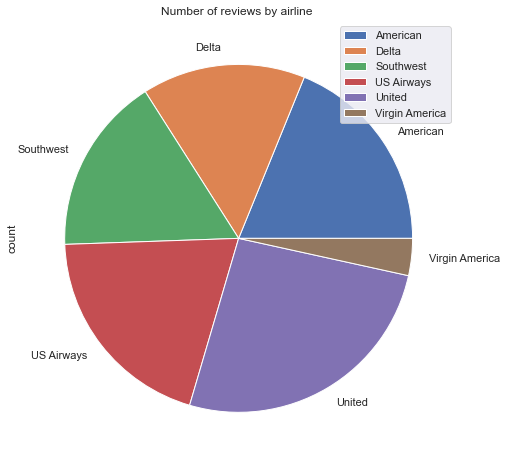

In [68]:
airline = tweets.iloc[:,4]
count = count = [1 for i in range(len(tweets))]
data = pd.DataFrame()
data["count"] = count
data["airline"] = airline
data = data.groupby(["airline"]).sum()
data.plot.pie(y="count").set(title="Number of reviews by airline ")

The pie plot shows the number of reviews by airline company. We notice that most reviews were written for United airlines, and the least for Virgin America airlines, while the others share almost equally the rest.

[Text(0.5, 1.0, 'Sentiment by airline')]

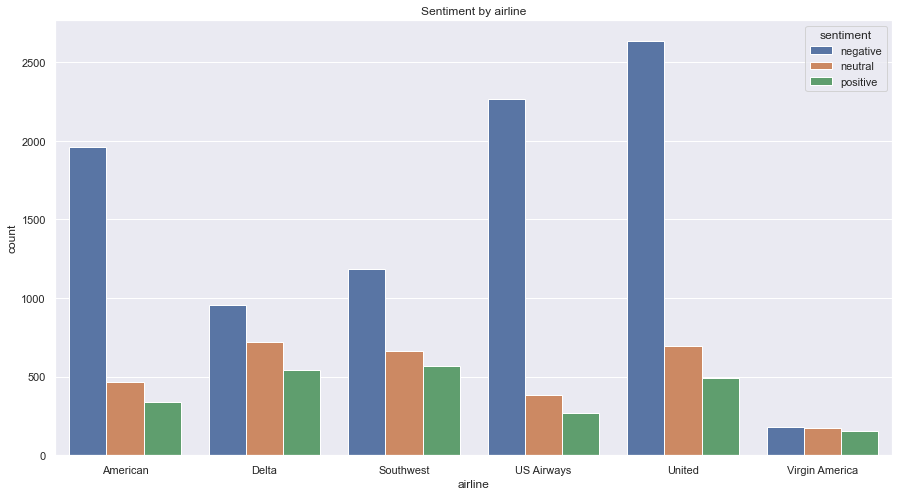

In [69]:
airline = tweets.iloc[:,4]
count = count = [1 for i in range(len(tweets))]
sent = tweets.iloc[:,0]
data = pd.DataFrame()
data["count"] = count
data["airline"] = airline
data["sentiment"] = sent
data = data.groupby(["airline","sentiment"]).sum().reset_index()
sns.barplot(data=data, x="airline",y="count",hue="sentiment").set(title="Sentiment by airline")

The bar plot above shows us the sentiment by airline. Overall the dominant feeling is negative especially for United airlines, US airways and American airlines. By contrast Virgin America airlines have an almost equal amount of negative reviews as it does of neutral and positive reviews.

[Text(0.5, 1.0, 'negtive reasons')]

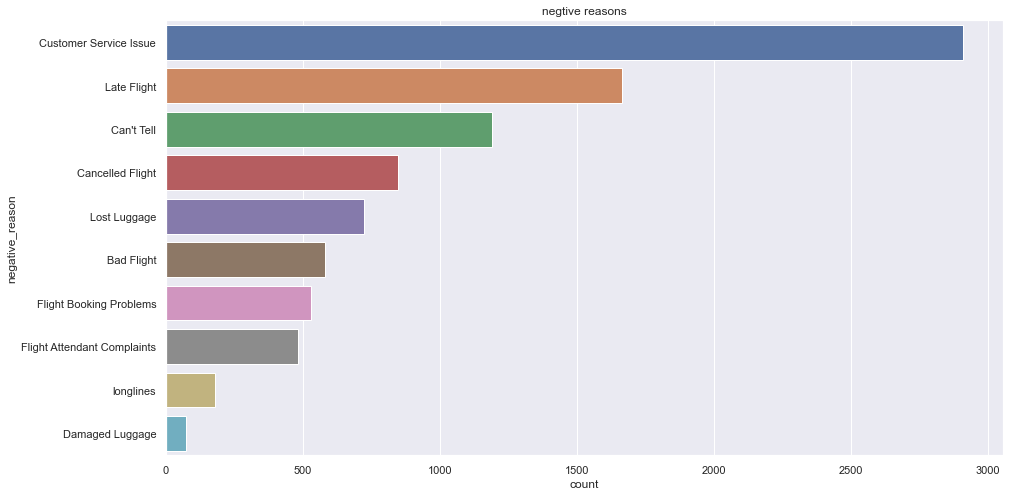

In [70]:
rea = tweets.iloc[:,2]
count = count = [1 for i in range(len(tweets))]
data = pd.DataFrame()
data["count"] = count
data["negative_reason"] = rea
data = data.groupby("negative_reason").sum().reset_index()
data = data.sort_values(by="count",ascending = False)
sns.barplot(data=data, x="count", y="negative_reason").set(title="negtive reasons")

Here we see the negative resons cited by people, the most dominant one is customer service followed by flights delay and cancellation and luggage loss.

[Text(0.5, 1.0, 'Retweets by sentiment ')]

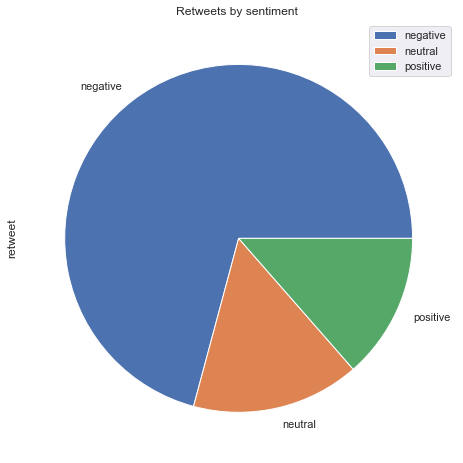

In [71]:
sent = tweets.iloc[:,0]
ret = tweets.iloc[:,5]
data = pd.DataFrame()
data["sentiment"] = sent
data["retweet"] = ret
data = data.groupby("sentiment").sum()
data.plot.pie(y="retweet").set(title="Retweets by sentiment ")

Then we see the amount of retweets by sentiment and we notice that negative reviews are retweeted more often, but this might be because negative tweets are dominant in the first place.

[Text(0.5, 1.0, 'Amount of tweets by location')]

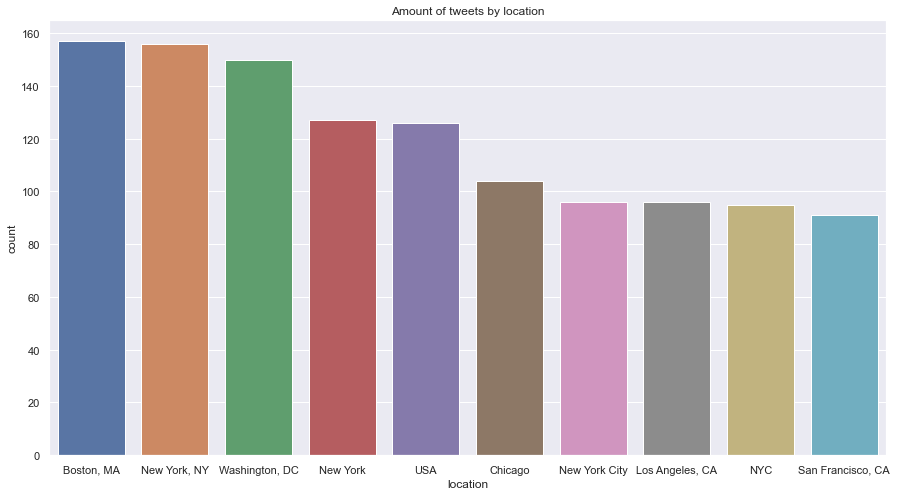

In [72]:
loc = tweets.iloc[:,8]
count = count = [1 for i in range(len(tweets))]
data = pd.DataFrame()
data["count"] = count
data["location"] = loc
data = data.groupby("location").sum().reset_index()
data = data.sort_values(by="count", ascending=False)
data = data.head(10)
sns.barplot(data = data,x="location", y="count").set(title="Amount of tweets by location")

Then we see the amount of tweets by location, we notice that New York exists more than once under differently spelled names and overall the top places from which tweets happen are New York, Washington, Boston, SF... because they are areas of high populations.

In [73]:
tweets.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14640 entries, 0 to 14639
Data columns (total 9 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   airline_sentiment             14640 non-null  object 
 1   airline_sentiment_confidence  14640 non-null  float64
 2   negativereason                9178 non-null   object 
 3   negativereason_confidence     10522 non-null  float64
 4   airline                       14640 non-null  object 
 5   retweet_count                 14640 non-null  int64  
 6   text                          14640 non-null  object 
 7   tweet_created                 14640 non-null  object 
 8   tweet_location                9907 non-null   object 
dtypes: float64(2), int64(1), object(6)
memory usage: 1.0+ MB


In [75]:
# Dropping the timestamp part 
def date_time(df, cols):
    for col in cols:
        df[col] = pd.to_datetime(df[col], format='%Y-%m-%d').dt.date
date_time(tweets,["tweet_created"])
tweets.sort_values(by = 'tweet_created', inplace = True)

In [79]:
date = tweets.iloc[:,7]
count = count = [1 for i in range(len(tweets))]
data = pd.DataFrame()
data["count"] = count
data["date"] = date

In [80]:
# Converting "tweet_created" column to datetime then int to group the ds by it
data["date"]= data['date'].astype('datetime64')
def datetime_to_int(dat, cols):
    for col in cols:
        dat[col] = dat[col].values.astype(np.int64)
datetime_to_int(data, ["date"])
data = data.groupby("date").sum().reset_index()

Text(0.5, 1.0, 'Number of tweets by time')

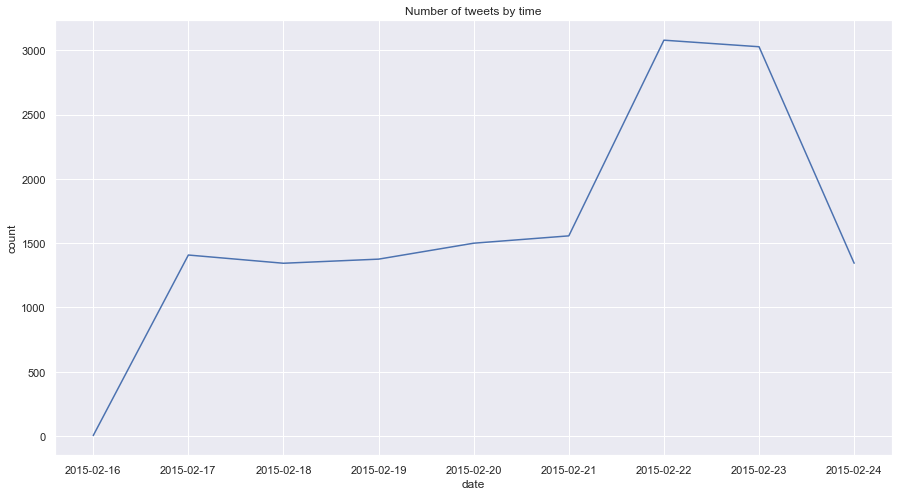

In [81]:
# Converting it back to datetime and ploting the time series
data["date"]= data['date'].astype('datetime64[ns]')
data = data.sort_values(by="date",ascending=True)
fig,ax = plt.subplots()
ax = sns.lineplot(data = data,  x="date", y="count")
ax.set_title("Number of tweets by time")

Here we've got the number of tweets by time and we notice a spike in tweets between the 22nd and 23rd of February 2015.